In [1]:
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
import wave
from scipy.fftpack import fft
from numpy.fft import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM, Layer, Activation, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from pathlib import Path
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import h5py
train_audio_path = Path(r'F:\speech recognition\greek_dataset_phylology_dept') #GREEK DATASET
# train_audio_path = Path(r'D:\speech recognition\train\audio') #ENGLISH DATASET
noise_path=Path(r'F:\speech recognition\_background_noise_') #NOISE DIRECTORY
SAMPLE_RATE=16000

Preprocessing

In [ ]:
##preprocessing and feature extraction
tamikimeta=[]
# def create_df(path): #LOADING ENGLISH DATA
#     tmp_list=[]
#     for dirpath, dirnames, filenames  in (os.walk(path)) :
#         if dirpath != os.path.join(path, "_background_noise_" ) and  dirpath is not path :  
#             # print(dirpath)
#             for file in filenames:
#                 if file.endswith('.wav'):
#                     tmp_path=os.path.join(dirpath, file)
#                     class_label = tmp_path.split('\\')[-2] 
#                     tmp_list.append([tmp_path,class_label])
#                 else:
#                     continue
#     return  pd.DataFrame(tmp_list,columns=['file_path','word_label'])
def create_df(path): #LOADING GREEK DATA
    tmp_list=[]
    files = [f for f in os.listdir(str(train_audio_path)) if f.endswith('.wav')]
    for file in files:
        if file.endswith('.wav'):
            tmp_path=os.path.join(path, file)
            word_label= file.split('_')[-2]
            tmp_list.append([tmp_path,word_label])
        else:
            continue
    return  pd.DataFrame(tmp_list,columns=['file_path','word_label']) #dataframe containing the path for each word

def findmaxlength(audio_path,lengths): #FUNCTION WHICH FINDS THE TIMESERIES WITH THE MOST SAMPLES

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    lengths.append(len(data))
    
    return lengths

def extract_feat(data,sr): #FEATURE EXTRACTION AND STACKING TO AN ARRAY
    image_w_features = np.array([])

    mfcc = librosa.feature.mfcc(data,sr=sr,n_mfcc=13,n_fft=2048,hop_length=512).T
                    
    zcr=librosa.feature.zero_crossing_rate(data, frame_length=2048, hop_length=512, center=True).T
    
    spectral_roloff=librosa.feature.spectral_rolloff(data, sr=sr,n_fft=2048, hop_length=512,center=True).T
    
    chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=512).T
    
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr,hop_length=512,n_fft=2048, center=True).T

    image_w_features=np.hstack((mfcc,zcr))

    image_w_features=np.hstack((image_w_features,spectral_roloff))
    image_w_features=np.hstack((image_w_features,chromagram))
    image_w_features=np.hstack((image_w_features,spec_bw))
 
    return image_w_features

def get_feat_padded(audio_path,megistomikos): #ZERO PADDING FOR EQUAL LENGTH TIMESERIES

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    
    if len(data)<megistomikos:
        poso=int((megistomikos-len(data))/2)
        data=np.pad(data, pad_width=(poso, poso), mode='constant')
    
    #ta miki

    tamikimeta.append(len(data))
    feat = extract_feat(data,SAMPLE_RATE)
    image_feat = np.array(feat)

    return image_feat

lengths=[]
X, Y, paths = [], [], []

speech_dataframe=create_df(train_audio_path)
speech_dataframe = speech_dataframe.sample(frac = 1) #shuffling dataframe rows
# speech_dataframe=speech_dataframe.groupby('word_label').apply(lambda x: x.sample(300))
for path in speech_dataframe.file_path:
    miki= findmaxlength(path,lengths)
    
maxmikos=max(miki)
print(maxmikos)

for path, word in zip(speech_dataframe.file_path, speech_dataframe.word_label): #CREATE FEATURE AND CATEGORY VECTORS

    features=get_feat_padded(path,maxmikos)
    X.append(features)
    Y.append(word) 
    paths.append(path)

tameta=np.array(tamikimeta)        
plt.hist(tameta)

Scaling extracted features

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
Xnew=X
Ynew=Y
#scaling and encoding
scaler = StandardScaler()
#X_simple=np.array(X)
Xnew=np.array(Xnew)
Xnew = scaler.fit_transform(Xnew.reshape(-1, Xnew.shape[-1])).reshape(Xnew.shape)

Get vocabulary for the current dataset

In [4]:
vocab = u"αβγδεζηθικλμνξοπρστυφχψως-' " #GREEK DATA VOCABULARY
# vocab = u"abcdefghijklmnopqrstuvwxyz- " #ENGLISH DATA VOCABULARY
print(sorted(vocab))
max_label_len = max([len(str(text)) for text in Ynew])

[' ', "'", '-', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω']


Functions for encoding words to fixed length array of numbers and decoding respectively

In [5]:
import unicodedata as ud
char_list = sorted(vocab)
def char_to_num(label):
    label_num = []
    d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
    label=ud.normalize('NFD',label).translate(d)
    for index,ch in enumerate(label):
        label_num.append(char_list.index(ch))
        
    return pad_sequences([label_num], maxlen=max_label_len, padding='post')[0]

def num_to_char(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=char_list[ch]
    return ret

In [6]:
padded_texts = list(map(char_to_num, Ynew))
print(Ynew[3],padded_texts[3], type(padded_texts[3]))

το [22 17  0  0  0  0  0] <class 'numpy.ndarray'>


In [7]:
# In the first step we will split the data in training and test dataset
X_train, X_test, Y_train, Y_test = train_test_split(Xnew,padded_texts,test_size=0.20)

# Now since we want the valid and test size to be equal (10% each of overall data). we have to define test_size=0.50 (that is 50% of test data)
X_test, X_validation, Y_test, Y_validation = train_test_split(X_test,Y_test, test_size=0.50)

In [8]:
def encode_single_sample(features, label):
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    #label = list(map(lambda x:char_to_num(x), label))
    return {"features": features, "label": label}

In [9]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size, drop_remainder= True) #https://stackoverflow.com/questions/58958437/tf-data-dataset-the-batch-size-argument-must-not-be-specified-for-the-given-i
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size, drop_remainder= True)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size, drop_remainder= True)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

Creating CTC layer and CRNN model

In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        # self.loss_fn = tf.nn.ctc_loss()


    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

#3D->4D array for input of CNN
X_train=X_train[..., np.newaxis]
X_validation=X_validation[..., np.newaxis]
X_test=X_test[..., np.newaxis]

def build_model():
    # Inputs to the model
    input_feat = layers.Input(
        shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), name="features", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="int32")

    # First conv block
    x = layers.Conv2D(64,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_feat)
    # x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)

    # Second conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    # x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)

    # x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv3")(x)
    # x = layers.MaxPooling2D((2, 2), name="pool3")(x)
    # x = layers.BatchNormalization(name="conv_3_bn")(x)    

    Conv_Shape = x.get_shape( )
    x = Reshape( target_shape=(int(Conv_Shape[1]),int(Conv_Shape[2]*Conv_Shape[3])), name='Reshape' )(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Output layer
    x = layers.Dense(len(vocab) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_feat, labels], outputs=output, name="CRNN_Model_with_CTC_LOSS"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)#,metrics=["accuracy"])
    return model


# Get the model
model = build_model()
model.summary()

Model: "CRNN_Model_with_CTC_LOSS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 39, 28, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 39, 28, 64)   640         features[0][0]                   
__________________________________________________________________________________________________
conv_1_bn (BatchNormalization)  (None, 39, 28, 64)   256         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 39, 28, 32)   18464       conv_1_bn[0][0]                  
___________________________________________________________________________

In [11]:
epochs = 50 
batch_size=32
steps_per_epoch=len(X_train)//batch_size
validation_steps=len(X_validation)//batch_size
early_stopping_patience = 5 #https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#filepath="CRNN.h5"
filepath='model.{epoch:02d}-{val_loss:.2f}.h5'
# Add early stopping
early_stopping = EarlyStopping(
     monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True,verbose=1, min_delta=0.001, mode="min"
 )

# Model Check Point
check_point = ModelCheckpoint( filepath=filepath,   # filepath 'model.{epoch:02d}-{val_loss:.2f}.h5'
    monitor='val_loss',save_best_only=True,verbose=1,save_freq='epoch' 
)
#early_stopping = BatchEarlyStopping(monitor="val_loss", patience=early_stopping_patience)# restore_best_weights=True,verbose=1, min_delta=0.001)

#https://stackoverflow.com/questions/38340311/what-is-the-difference-between-steps-and-epochs-in-tensorflow
#https://stackoverflow.com/questions/47462114/gpu-only-being-used-1-5-tensorflow-gpu-and-keras
# Train the model
# with tf.device('/gpu:0'):
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,use_multiprocessing=True, workers=8,
        #steps_per_epoch=steps_per_epoch,validation_steps= validation_steps,
        epochs=epochs,callbacks=[early_stopping]) #,check_point

Epoch 1/50
546/546 [==============================] - 79s 110ms/step - loss: 10.1639 - val_loss: 8.2037
Epoch 2/50
546/546 [==============================] - 49s 90ms/step - loss: 7.4282 - val_loss: 6.3919
Epoch 3/50
546/546 [==============================] - 52s 96ms/step - loss: 5.9140 - val_loss: 4.9518
Epoch 4/50
546/546 [==============================] - 50s 92ms/step - loss: 4.7611 - val_loss: 3.9967
Epoch 5/50
546/546 [==============================] - 50s 91ms/step - loss: 3.9488 - val_loss: 3.3813
Epoch 6/50
546/546 [==============================] - 50s 92ms/step - loss: 3.2292 - val_loss: 2.6540
Epoch 7/50
546/546 [==============================] - 50s 91ms/step - loss: 2.7000 - val_loss: 2.4716
Epoch 8/50
546/546 [==============================] - 50s 91ms/step - loss: 2.3717 - val_loss: 2.2117
Epoch 9/50
546/546 [==============================] - 50s 91ms/step - loss: 2.1427 - val_loss: 2.0982
Epoch 10/50
546/546 [==============================] - 50s 91ms/step - loss: 1.9

CRNN model architecture

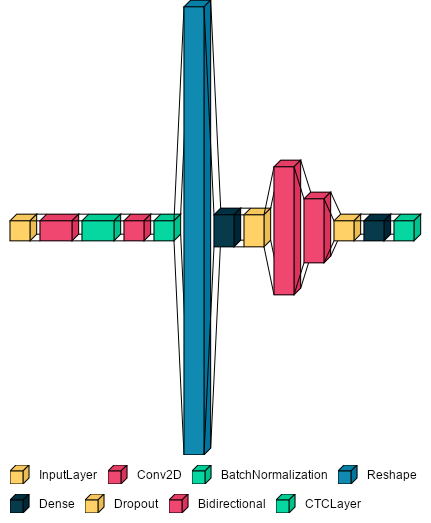

In [25]:
import visualkeras
visualkeras.layered_view(model, legend=True, background_fill= "white") # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font, background_fill= "white", scale_xy=0.5, scale_z=0.5, max_z=1000) # selected font

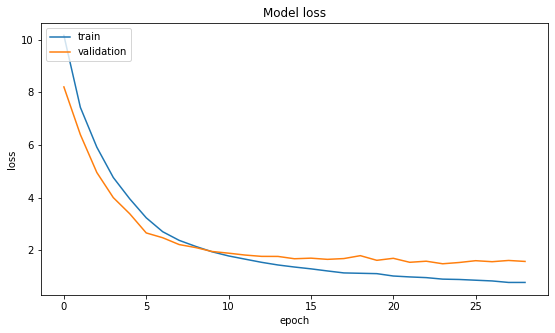

In [12]:
fig=plt.figure(figsize=(20, 5))

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="features").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_label_len
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

CRNN model evaluation

In [14]:
from jiwer import wer
#  Let's check results on some test samples
for batch in test_dataset.take(1):
    batch_features = batch["features"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_features)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    
    tot_correct=0
    tot_count=len(preds)
    for pred,orig in zip(pred_texts,orig_texts):
        if pred==orig:
            tot_correct+=1

print(f"Accuracy: {tot_correct/tot_count:.4f}")

wer_score = wer(orig_texts, pred_texts)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in range(len(pred_texts)):#np.random.randint(0, len(pred_texts), 10):
    print(f"Target    : {orig_texts[i]}")
    print(f"Prediction: {pred_texts[i]}")
    print("-" * 100)
#     _, ax = plt.subplots(4, 4, figsize=(15, 5))
#     for i in range(len(pred_texts)):
#         img = (batch_features[i] ).numpy().astype(np.uint8)
#         #img = img.T
#         title = f"Prediction: {pred_texts[i]}"
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")
# plt.show()

Accuracy: 0.9062
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.0625
----------------------------------------------------------------------------------------------------
Target    : σε     
Prediction: σε     
----------------------------------------------------------------------------------------------------
Target    : βοριας 
Prediction: βοριας 
----------------------------------------------------------------------------------------------------
Target    : να     
Prediction: να     
----------------------------------------------------------------------------------------------------
Target    : μας    
Prediction: μνας   
----------------------------------------------------------------------------------------------------
Target    : την    
Prediction: την    
----------------------------------------------------------------------------------------------------
Target    : να     
Prediction: να     
------------